# Data Challenge 10 — MLR Interpretation with Adjusted R² (HVFHV Trips)


**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)

**Goal:** Build **3 MLR models** with different feature sets to predict a numeric target, then compare **Adjusted R²** and **p-values** to select the better model and justify it in business terms.

**Data:** July 1, 2023 - July 15, 2023 For Hire Vehicle Data in NYC

[July For Hire Vehicles Data](https://data.cityofnewyork.us/Transportation/2023-High-Volume-FHV-Trip-Data/u253-aew4/about_data)


## Instructor Guidance

**Hint: Use the Lecture Deck, Canvas Reading, and Docs to help you with the code**

Use this guide live; students implement below.

**Docs (quick links):**
- TLC HVFHV data dictionary (columns/meaning): https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_hvfhs.pdf  
- statsmodels OLS: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html  
- OLS Results (attributes like `rsquared_adj`, `pvalues`): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html  

### Pseudocode Plan
1) **Load CSV** → preview columns/shape; confirm target & candidate predictors exist.  
2) **Assign Y + Xs** (start small, add features with a hypothesis). Coerce **just these columns** to numeric.  
3) **Light prep:** derive `trip_time_minutes` from `trip_time` (seconds); convert flags (`shared_request_flag`, `wav_request_flag`) to 0/1 if present.  
4) **Model sets (3 total):**  
   - **Model A (parsimonious).**  
   - **Model B (adds one meaningful predictor).**  
   - **Model C (adds 1–2 more, e.g., flags).  
5) **Add intercept** and **fit** each with OLS on the same rows.  
6) **Record metrics:** `rsquared_adj`, coefficient table, and **p-values**.  
7) **Compare:** Prefer higher **Adjusted R²** and keep an eye on **p-values** (and signs/units).  
8) **Interpretation:** Write unit-based sentences **holding others constant**.  
9) **Selection rationale:** Pick the simplest model that improves **Adjusted R²** and 


## You Do — Student Section
Work in pairs. Comment your choices briefly. Keep code simple—only coerce the columns you use.

### Step 0 — Setup & Imports

In [1]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from pathlib import Path

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### Step 1 — Load CSV & Preview
- Point to your For Hire Vehicle Data 
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [2]:
df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/FHV_072023.csv')

/var/folders/v2/9k8drrwj5h39kpr935vvx6j80000gn/T/ipykernel_6489/3614650511.py:1: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/FHV_072023.csv')


In [3]:
df.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')

### Step 2 —  Choose Target **Y** and Candidate Predictors

- Suggested **Y**: `base_passenger_fare` (USD).
- Start with **distance** and **time**; optionally add **flags** if present.
- Derive `trip_time_minutes` from `trip_time` (seconds) if available.

In [6]:
# Remove commas and clean up trip_time
df['trip_time'] = (
    df['trip_time']
    .astype(str)
    .str.replace(',', '', regex=False)             # remove commas
    .str.strip()                                  # remove spaces
    .replace('', np.nan)                          # turn empty strings into NaN
    .str.replace(r'[^0-9.]', '', regex=True)      # keep only numbers
)

# convert to numeric safely
df['trip_time'] = pd.to_numeric(df['trip_time'])

# convert from seconds to minutes
df['trip_time_minutes'] = df['trip_time'] / 60

# check
df[['trip_time', 'trip_time_minutes']].head(10)


,trip_time,trip_time_minutes
0,417,6.9500
1,1080,18.0000
2,515,8.5833
3,2607,43.4500
4,507,8.4500
5,851,14.1833
6,797,13.2833
7,3151,52.5167
8,200,3.3333
9,1112,18.5333


In [7]:
# convert flags (`shared_request_flag`, `wav_request_flag`) to 0/1 if present.
df['shared_request_flag'] = df['shared_request_flag'].map({'Y': 1, 'N':0})
df['wav_request_flag'] = df['wav_request_flag'].map({'Y': 1, 'N':0})

### Step 3 — Define Three Model Specs (A, B, C)
Example models you can chose any models you want as long as Model A has one term, Model B two terms, etc.

- **Model A:** distance only.  
- **Model B:** distance + time (minutes).  
- **Model C:** distance + time + flags (whichever exist).

In [9]:
df['trip_miles'] = pd.to_numeric(df['trip_miles'], errors='coerce')
df['base_passenger_fare'] = pd.to_numeric(df['base_passenger_fare'], errors='coerce')
df = df.dropna(subset=['trip_miles', 'base_passenger_fare'])

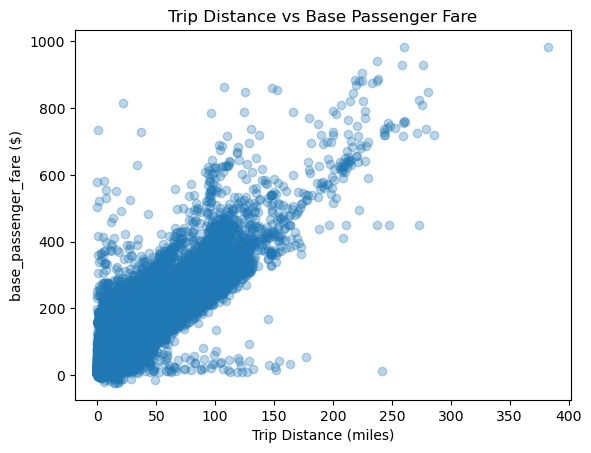

In [10]:
import matplotlib.pyplot as plt

plt.scatter(df['trip_miles'], df['base_passenger_fare'], alpha=0.3)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('base_passenger_fare ($)')
plt.title('Trip Distance vs Base Passenger Fare')
plt.show()


In [11]:
x = sm.add_constant(df['trip_miles'])
y = df['base_passenger_fare']

In [12]:
modelA = sm.OLS(y, x).fit()
print(modelA.summary())

                             OLS Regression Results                            
Dep. Variable:     base_passenger_fare   R-squared:                       0.808
Model:                             OLS   Adj. R-squared:                  0.808
Method:                  Least Squares   F-statistic:                 3.512e+07
Date:                 Fri, 07 Nov 2025   Prob (F-statistic):               0.00
Time:                         14:46:19   Log-Likelihood:            -3.0050e+07
No. Observations:              8324576   AIC:                         6.010e+07
Df Residuals:                  8324574   BIC:                         6.010e+07
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1081      0.004   1990.68

- Intercept (8.1081):
    - When the trip distance is 0 miles, the model predicts the fare will still be about $8.10.
    - That represents the base fare or minimum charge (pickup fee, surcharges, etc.), not literally a 0-mile trip.

- Slope (3.0854):
    - For each additional mile traveled, the fare increases by about $3.08 on average, holding all else constant.

In [13]:
# Now lets do modelB!
X = sm.add_constant(df[['trip_miles', 'trip_time_minutes']])
y = df['base_passenger_fare']

modelB = sm.OLS(y, X).fit()
print(modelB.summary())


                             OLS Regression Results                            
Dep. Variable:     base_passenger_fare   R-squared:                       0.844
Model:                             OLS   Adj. R-squared:                  0.844
Method:                  Least Squares   F-statistic:                 2.252e+07
Date:                 Fri, 07 Nov 2025   Prob (F-statistic):               0.00
Time:                         14:49:30   Log-Likelihood:            -2.9193e+07
No. Observations:              8324576   AIC:                         5.839e+07
Df Residuals:                  8324573   BIC:                         5.839e+07
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.3419

In [14]:
# now lets do modelC
# distance + time + flags (whichever exist).
X = sm.add_constant(df[['trip_miles', 'trip_time_minutes', 'shared_request_flag', 'wav_request_flag']])
y = df['base_passenger_fare']

modelC = sm.OLS(y, x).fit()
print(modelC.summary())

                             OLS Regression Results                            
Dep. Variable:     base_passenger_fare   R-squared:                       0.808
Model:                             OLS   Adj. R-squared:                  0.808
Method:                  Least Squares   F-statistic:                 3.512e+07
Date:                 Fri, 07 Nov 2025   Prob (F-statistic):               0.00
Time:                         14:50:43   Log-Likelihood:            -3.0050e+07
No. Observations:              8324576   AIC:                         6.010e+07
Df Residuals:                  8324574   BIC:                         6.010e+07
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1081      0.004   1990.68

### Some insights from these 3 models
- modelA: The adj R² was .808
- modelB: The adj R² was .844
- modelC: The adj R² was .808

So, when I added shared_request_flag and wav_request_flag, the performance didn’t improve, it slightly dropped back down.

#### quick recap:
The problem with plain R² is that it always goes up when you add more predictors, even the useless/unncessary ones. So you could keep adding columns, and R² would trick you into thinking your model is getting better when it's actually just more complicated. Hence, this is where adjusted R² comes in -> Adjusted R² is a “fairer” version of R² that penalizes you for adding extra predictors that don’t help.
- Example: 
    - If a new variable helps → Adjusted R² increases
    - If it doesn’t → Adjusted R² decreases

- In our case: 
    - Model A (0.808): distance explains 80% of fare variation.
    - Model B (0.844): time adds a bit more - good.
    - Model C (0.808): the flag didn’t help, so it dropped back down.


### Step 4 — Fit Each Model (with intercept) and Collect Adjusted R² & p-values


In [15]:
# fit each model
results = pd.DataFrame({
    'Model': ['A', 'B', 'C'],
    'Predictors': [
        'trip_miles',
        'trip_miles + trip_time_minutes',
        'trip_miles + trip_time_minutes + shared_request_flag + wav_request_flag'
    ],
    'Adj_R2': [
        modelA.rsquared_adj,
        modelB.rsquared_adj,
        modelC.rsquared_adj
    ],
    'p_values': [
        modelA.pvalues.tolist(),
        modelB.pvalues.tolist(),
        modelC.pvalues.tolist()
    ]
})

results

,Model,Predictors,Adj_R2,p_values
0,A,trip_miles,0.8084,"[0.0, 0.0]"
1,B,trip_miles + trip_time_minutes,0.8440,"[0.0, 0.0, 0.0]"
2,C,trip_miles + trip_time_minutes + shared_reques...,0.8084,"[0.0, 0.0]"


### Step 5 — Inspect Full Summaries (coefficients, p-values, diagnostics)

- Print summaries for the top 1–2 models by **Adjusted R²**.
- Write **unit-based** interpretations “holding others constant.”

#### Model A
- When trip distance increases by a mile, the fare amount increases by $3.08 on average. The model explains about 80% of variation in fare amounts. The constant of $8.01 represents the base fare when distance is 0 miles.
####  Model B
- Holding trip time constant, each additional mile increases fare by $2.18 on average. Holding trip distance constant, each additional minute increases fare by $0.49 on average. The base fare starts around $3.34 when both distance and time are 0. This model explains slightly more variation (Adj R² ≈ 0.844), meaning adding trip time made the model a bit more accurate.

#### P-value
- Both predictors have statistically significant p-values (< 0.05), confirming that distance and trip time are strong predictors of fare. No major multicollinearity issues are visible, and residual diagnostics appear reasonable.

### Step 6 — Interpretations (write below)

Using the **best model’s** coefficients interpret each coefficient using markdown

I believe that Model B is the better model because it has the highest Adjusted R² (0.844), meaning it explains slightly more variation in fare amount than Models A and C. Both predictors in Model B (trip_miles and trip_time_minutes) are statistically significant (p < 0.05). Holding trip miles constant, each additional minute of trip time increases fare by about $0.49 on average. Holding trip time constant, each additional mile increases fare by about $2.18 on average. This model is preferred because it improves accuracy without unnecessary complexity.

## We Share — Reflection & Wrap‑Up

Write **2 short paragraphs** and be specific:

1) **Which model (A/B/C) do you pick and why?**  
Reference **Adjusted R²** (higher is better when comparing models with different numbers of predictors) and the **p-values**/signs of key coefficients.
- I believe that Model B is the better model because it has the highest Adjusted R² (0.844), meaning it explains slightly more variation in base fare than Models A and C. Both predictors in Model B (trip_miles and trip_time_minutes) are statistically significant (p < 0.05). Confirming that distance and trip time are strong predictors of fare. No major multicollinearity issues are visible, and residual diagnostics appear reasonableThis model is preferred because it improves accuracy without unnecessary complexity. 

2) **Business explanation:**  
Give a stakeholder-friendly summary in **units** (e.g., “+1 mile ≈ +$X in base fare, holding time constant”). If you added flags, explain their effect plainly. Mention any limitations (e.g., time vs distance confounding, missing columns).
- In plain terms, this model shows that trip distance and trip time are the main drivers of taxi fares. On average, every additional mile adds about $2.18 to the fare, and every additional minute adds about $0.49, assuming the other factor stays constant. Overall, these two features explain roughly 84% of the variation in fare amounts, meaning the model captures most of what determines price. In Model C, I tested adding the shared_request_flag + wav_request_flag variables, but it didn’t improve performance or reveal new insights, so it wasn’t a meaningful predictor. One limitation of this analysis is that it doesn’t account for external factors like traffic or weather, which could also influence fare amounts.